# Micro-CT whole mouse lung segmentation

## Rosenhain, S., Magnuska, Z., Yamoah, G. et al. A preclinical micro-computed tomography database including 3D whole body organ segmentations. Sci Data 5, 180294 (2018). https://doi.org/10.1038/sdata.2018.294

Source: [Rosenhain 2018 Sci Data](https://www.nature.com/articles/sdata2018294)

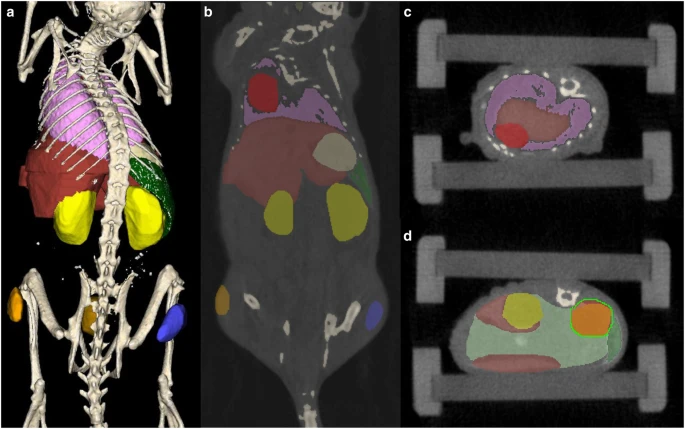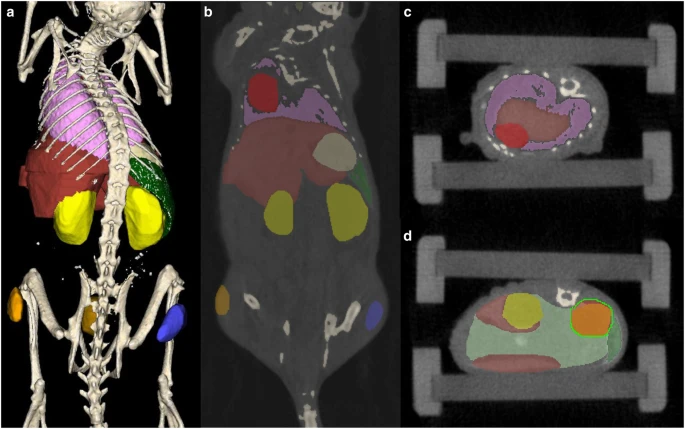

In [1]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='gray')

from preprocessing import download_and_unpack_data, Mouse, make_images_and_labels, make_paths

In [2]:
import os
homedir = os.environ['HOME']

rawpath = Path('/research/labs/radiology/ctcic/m163524/datasets/wholebody_mouse')
if homedir == '/home/brandon':
    rawpath = Path('/media/brandon/Data/Dev/Datasets/wholebody_mouse')

In [3]:
if not (rawpath/'1_nativeCTdata').exists():
    download_and_unpack_data(rawpath)

Some scans have 2 organ segmentations 'Organ1' and 'Organ2'

In [4]:
mice = (rawpath/'1_nativeCTdata').ls()
mice_list = [Mouse(m) for m in mice]

In [5]:
mice_list = [Mouse(m) for m in mice]

In [6]:
mice_list[0].exists()
class_dict = mice_list[0].classes()
class_dict

{'unclassified': 0,
 'Bone': 1,
 'Lung': 2,
 'Heart': 3,
 'Liver': 4,
 'Intestine': 5,
 'Bladder': 6,
 'Spleen': 7,
 'Stomach': 8,
 'Muscle': 9,
 'Kidneys': 10}

Check that `convert_lbl()` works using a mouse with a different class labeling scheme from `class_dict`. Using the *Heart* class to confirm

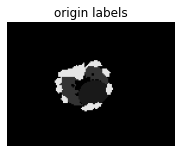

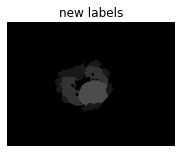

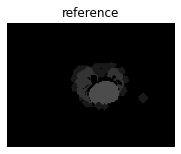

In [7]:
show_image(mice_list[2].load_lbl()[:,:,150], title='origin labels', vmin=0, vmax=10)
show_image(mice_list[2].convert_lbl(class_dict)[:,:,150], title='new labels', vmin=0, vmax=10)
show_image(mice_list[0].load_lbl()[:,:,150], title='reference', vmin=0, vmax=10)
organ='Heart'
assert np.array(mice_list[2].load_lbl()[:,:,150]==class_dict[organ]).sum() == 0
assert np.array(mice_list[2].convert_lbl(class_dict)[:,:,150]==class_dict[organ]).sum() > 0

<AxesSubplot:title={'center':'label'}>

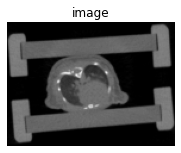

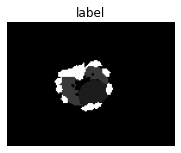

In [8]:
idx = 150
show_image(mice_list[2].load_img()[:,:,idx], title='image')
show_image(mice_list[2].load_lbl()[:,:,idx], title='label')

Let's confirm all mice are valid

In [9]:
assert len(mice_list) == 140
assert np.array([mouse.exists() for mouse in mice_list]).all()

## Now saveout masks and images into 'images' and 'labels' directories filled with pngs

copy, paste, and run the following block to delete the current images and labels files and make new ones from scratch

```python
import shutil
msk_path, img_path = make_paths()
if msk_path.exists() and img_path.exists():
    shutil.rmtree(msk_path)
    shutil.rmtree(img_path)
    
datafile, codefile = make_images_and_labels(rawpath)
```

In [10]:
codes = np.loadtxt('codes.txt', dtype=str)
df = pd.read_csv('data.csv')

In [11]:
codes

array(['unclassified', 'Bone', 'Lung', 'Heart', 'Liver', 'Intestine',
       'Bladder', 'Spleen', 'Stomach', 'Muscle', 'Kidneys'], dtype='<U12')

In [12]:
df 

,Unnamed: 0,Images,Masks
0,0,images/M01_0_0.png,labels/M01_0_0_P.png
1,1,images/M01_0_1.png,labels/M01_0_1_P.png
2,2,images/M01_0_2.png,labels/M01_0_2_P.png
3,3,images/M01_0_3.png,labels/M01_0_3_P.png
4,4,images/M01_0_4.png,labels/M01_0_4_P.png
...,...,...,...
31103,31103,images/M20_072h_282.png,labels/M20_072h_282_P.png
31104,31104,images/M20_072h_283.png,labels/M20_072h_283_P.png
31105,31105,images/M20_072h_284.png,labels/M20_072h_284_P.png
31106,31106,images/M20_072h_285.png,labels/M20_072h_285_P.png


In [13]:
assert len(df['Images']) == len(df['Masks'])

# Make Fastai DataLoaders

In [14]:
bs=64
def get_x(r): return r['Images']
def get_y(r): return r['Masks']
dblock = DataBlock(blocks =(ImageBlock, MaskBlock(codes)),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(100)
                   )
dls = SegmentationDataLoaders.from_dblock(dblock, df, bs=bs)

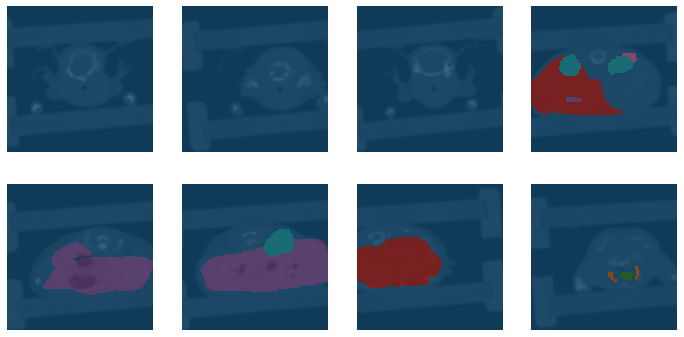

In [15]:
dls.train.show_batch(max_n=8)

In [20]:
learn = unet_learner(dls, resnet34, metrics=foreground_acc)

In [21]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,foreground_acc,time
0,0.089976,0.080951,0.716876,02:05


epoch,train_loss,valid_loss,foreground_acc,time
0,0.068557,0.071865,0.764305,02:19
1,0.061840,0.067305,0.757190,02:28
2,0.055032,0.053889,0.878485,02:24
3,0.045284,0.047037,0.884429,02:25
4,0.038389,0.040313,0.900851,02:25
5,0.032654,0.033301,0.916151,02:26
6,0.027576,0.030468,0.921024,02:27
7,0.025815,0.029904,0.921281,02:30


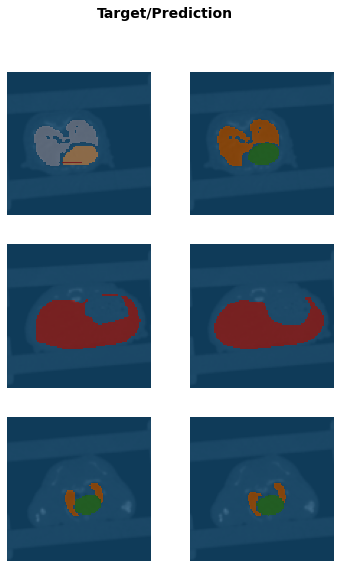

In [22]:
learn.show_results()